### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 (or 1/5, 2/5, etc.) (Laughlin state)
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Interaction Details
- **Coulomb Interaction**: V(q) = W₀ × 1/|ql|
- **Gate Screening**: tanh(qD) (finite gate distace)
- **Landau level projection**: exp(-0.5 × q²l²) level form factor
- **Form Factor**: See arXiv.2509.07784 Eq.(A28)
- **Units**: Energy in units of W₀ = e²/ϵl

### Key Physics
- **Periodic boundary conditions**: Torus geometry
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: 3-fold degenerate on torus for 1/3-filling Laughlin states

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(subtitle=nothing)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    if subtitle isa String
        ax_top.subtitle = subtitle
    end
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [2]:
# Define 3×5 k-mesh (Nk=15) for 1/3 filling Laughlin state calculation
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 5          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

5

In [3]:
# Define 3×6 k-mesh (Nk=18) for 1/3 filling Laughlin state calculation
# the three ground states will have the same total momentum

#=

k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

=#

In [4]:
# Define 9×9 k-mesh (Nk=27) for accurate Laughlin state calculation
# the three ground states will have the same total momentum
# Note: This setup needs more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
# Number of electrons for 1/3 filling
Ne = 9          # N electrons for this system

=#

In [5]:
# Define 6×5 k-mesh (Nk=30) for accurate Laughlin state calculation
# Note: This setup needs more time and memory
# Note: 32GB memory is recommended

#=

k_list = [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]

# System parameters
Nk = 30         # Total number of k-points
Gk = (6, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # N electrons for this system

=#

In [6]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction((1, 0, 1, 0));

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0)
@show intra_PP

# Haldane pseudo-potential
sys_int.V_intra = [0.0; 1.0; 0.0; 0.0]          # Intralayer Haldane pseudo-potential in unit of W0

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = k_list, Gk = Gk, V_int = sys_int);

intra_PP = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637]



In [7]:
# Create momentum blocks (Hilbert subspace)
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para, (Ne, ));
display(length.(subspaces))

# one-body terms are all zero in flat Landau level
scat = ED_sortedScatterList_twobody(para);

15-element Vector{Int64}:
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200

In [8]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 201, momentum 0, 0
  0.445324 seconds (624.15 k allocations: 33.011 MiB, 161.53% compilation time)
  2.589243 seconds (5.56 M allocations: 276.755 MiB, 0.69% gc time, 115.30% compilation time)
Processing subspace #2 with size 200, momentum 0, 1
  0.001469 seconds (234 allocations: 983.112 KiB)
  0.027533 seconds (2.41 k allocations: 1.037 MiB)
Processing subspace #3 with size 200, momentum 0, 2
  0.001742 seconds (245 allocations: 884.775 KiB)
  0.015419 seconds (2.41 k allocations: 1.038 MiB)
Processing subspace #4 with size 200, momentum 0, 3
  0.001302 seconds (269 allocations: 971.683 KiB)
  0.007686 seconds (2.41 k allocations: 1.038 MiB)
Processing subspace #5 with size 200, momentum 0, 4
  0.001327 seconds (298 allocations: 1.007 MiB)
  0.013612 seconds (2.41 k allocations: 1.038 MiB)
Processing subspace #6 with size 201, momentum 1, 0
  0.001420 seconds (227 allocations: 1.066 MiB)
  0.019399 seconds (3.43 k allocations: 1.537 MiB)
Processing su

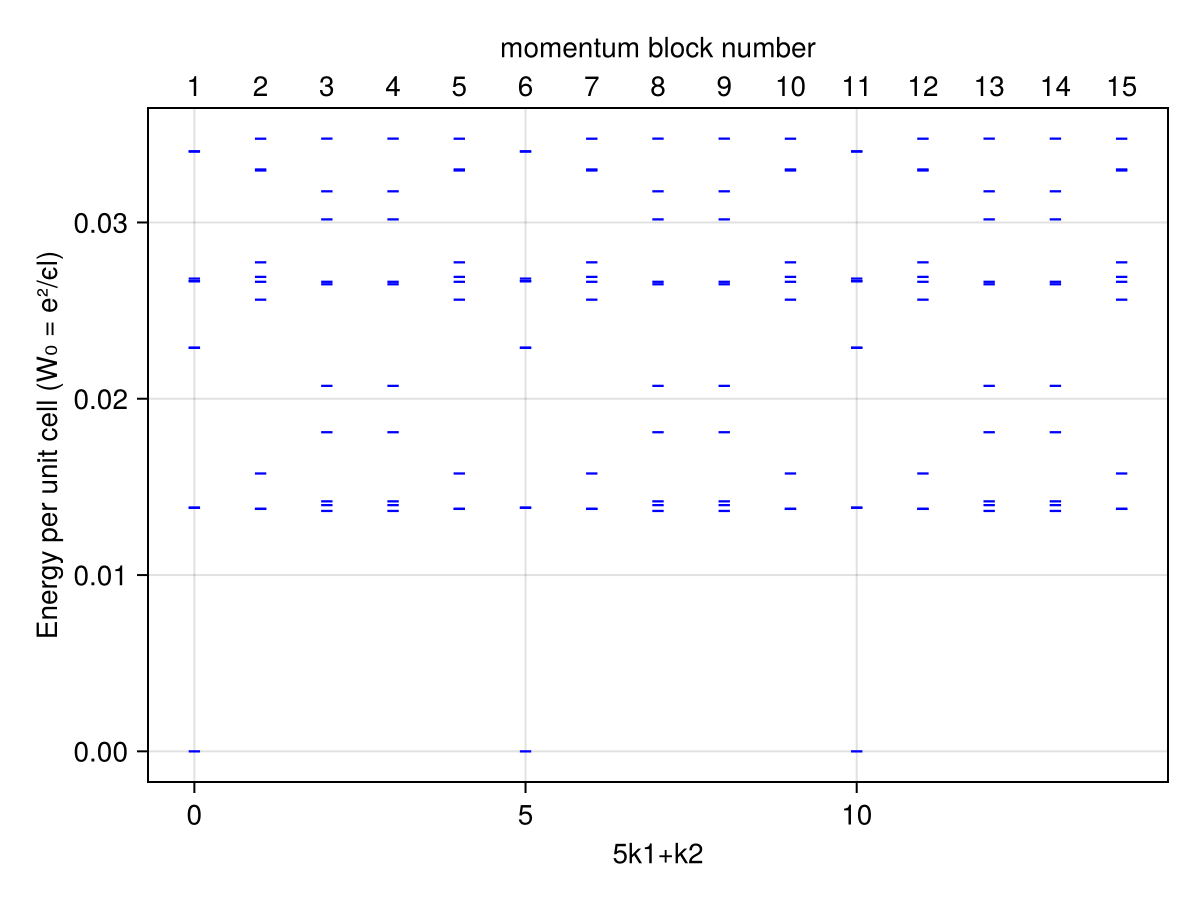

In [9]:
plot_ed_spectrum();

In [ ]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 -2.0013912673418553e-14
  0.013819857707607531
  0.013819857707607746
  0.022891695632190973
  0.022891695632191164
  0.02666976072108468
  0.026669760721084852
  0.02681525392845478
  0.03402882847903597
  0.03402882847903625

Compute and plot one-body reduced density matrix

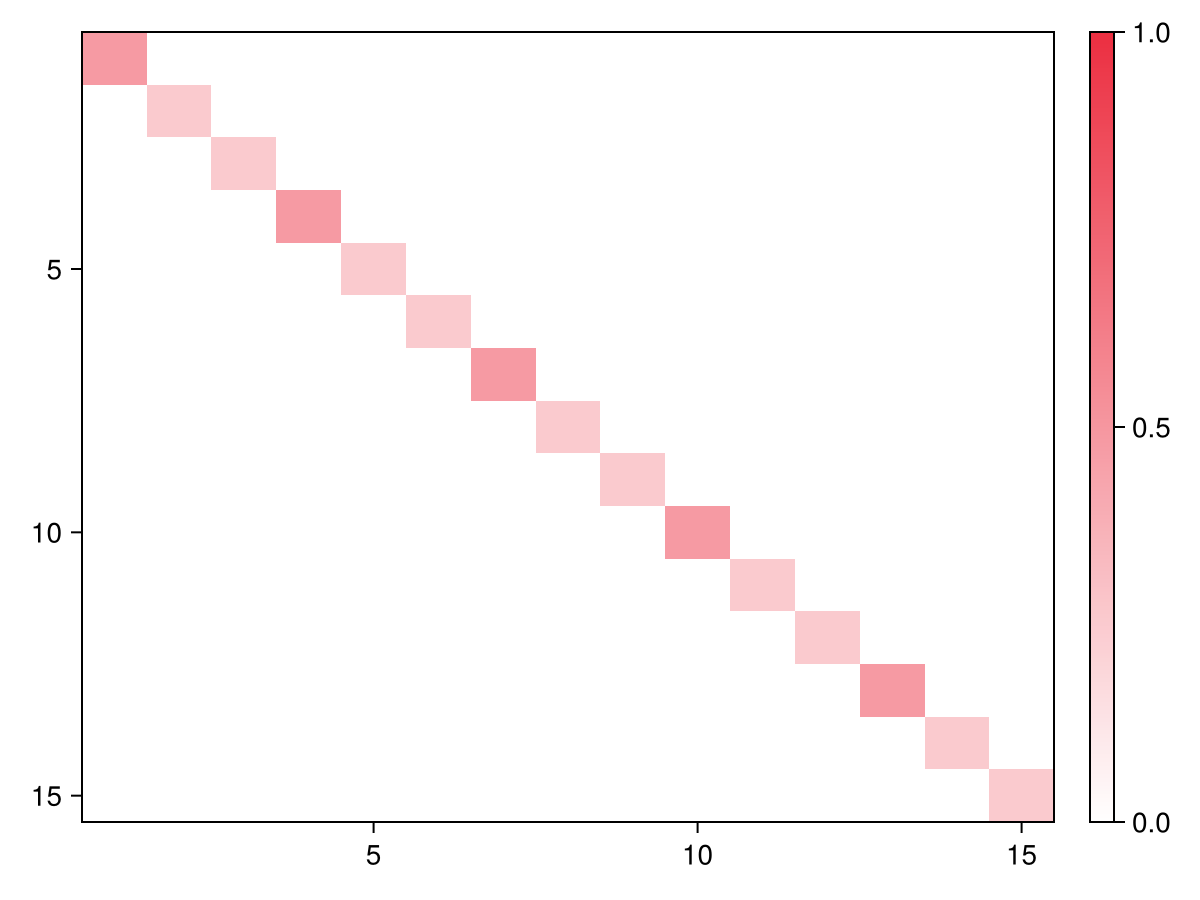

In [ ]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
sn = 1
rdm = ED_onebody_rdm(vectors[sn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [12]:
para.FF_inf_angle = LLT.Landau_ff_inf(sys_int); # Update the form factor in the parameter

# FF_inf_angle can be added after building para. 
# However, assertion for function inputs and output is not triggered. 
# See example 2 for including FF_inf_angle during para initialization.

#Landau_ff_inf##0 (generic function with 2 methods)

In [13]:
# path for the Wilson loop integral on base manifold
# Landau level has uniform Berry curvature, so we compute Berry curvature of a small plaquate and then multiply plaquate number
N_shift = 8  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.125, 0.0)
 (0.125, 0.125)
 (0.0, 0.125)
 (0.0, 0.0)

In [ ]:
# If the 3 ground states are in different momentum section, 
# we can track one of them and compute its many-body Chern number

#
sn = 1
psi_before = vectors[sn][1]
ED_connection_gaugefixing!(psi_before)  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatterList_twobody(para; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat_list; N = 6,
        showtime = false,
    )[2][1]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before = psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2
#

path point #1 	 (0.125, 0.0)
Inner product: amp = 0.9999999999999989, phase = -0.1308996938995766
path point #2 	 (0.125, 0.125)
Inner product: amp = 0.999999999999999, phase = 0.09490227807719277
path point #3 	 (0.0, 0.125)
Inner product: amp = 1.0000000000000016, phase = 0.14726215563702155
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.000000000000002, phase = -0.07853981633974745


0.33333333333329873

In [ ]:
# If the 3 degenerate ground states are in the same total momentum section, 
# we can only compute the sum of the tatal connection and Chern number.

#=
sn = 4
psi_before = vectors[sn][1:3]
ED_connection_gaugefixing!(psi_before)

using LinearAlgebra
WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    if path[i+1] == (0.0, 0.0)
        psi_after = vectors[sn][1:3]
        ED_connection_gaugefixing!(psi_after)
    else
        scat_list = ED_sortedScatterList_twobody(para; kshift = path[i+1]);
        psi_after = EDsolve(subspaces[sn], scat_list; N = 10,
            showtime = false, 
        )[2][1:3]
        ED_connection_gaugefixing!(psi_after)
    end

    WilsonLoopIntegral[i] = ED_connection_step(
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2

=#